### Crosswalking census tracts to jurisdictions using census block population as weights

Notebook relates census tracts to Bay Area jurisdictions, including the remainder of counties when incorporated areas are subtracted. The `jurisdictions` file fully encompasses the 9-county bay area.

To do the disaggregation, it assigns a tract to any jurisdictions that may contain parts of it not by land area but by the census block population, so we can answer the question:

`For tract x, what share of its population (accounted for at the block level) falls with jurisdiction A, B, C...`

An example is then provided showing the disaggregation using tenure data from the ACS.

`aolsen at bayareametro.gov`

In [1]:
import pandas as pd
import requests
import os
import feather as ft
import geopandas as gpd
apikey = os.getenv('CENSUS_API_KEY')

/Users/aolsen/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

In [3]:
def pct(x): return x/x.sum()

In [4]:
censusblocks_xy = gpd.read_file(
    'data/tl_2015_06_tabblock10_bayarea_xy.shp')


<AxesSubplot:>

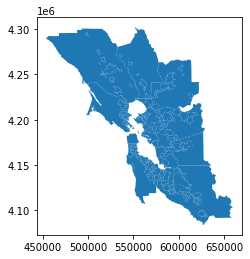

In [5]:
# made from 2020 tiger files
jurisdictions = gpd.read_file(
    'data/places_w_remainder_uninc_complete_2020_vintage.shp')
jurisdictions.plot()

### Get Census Data at Tract Level

In [29]:
# set inputs for census call
units_tbl = ['B25003_002E','B25003_003E']
units_tbl_str =','.join(units_tbl)
vintage=2019
dataset='acs5'
survey='acs'
geo='tract'

In [30]:
acs_url='https://api.census.gov/data/{vintage}/{survey}/{dataset}?key={key}&get={tbl}&for={geo}&in=state:06'.format(key=apikey,tbl=units_tbl_str,vintage=vintage,dataset=dataset,geo=geo,survey=survey)
dict_url=['https://api.census.gov/data/{vintage}/{survey}/{dataset}/variables/{tbl}.json'.format(tbl=t,vintage=vintage,survey=survey,dataset=dataset) for t in units_tbl]

In [31]:
datadicts = [pd.read_json(d, typ='series', orient='columns')
             for d in dict_url]
datadict = pd.DataFrame(datadicts).set_index('name').label.to_dict()
datadict

{'B25003_002E': 'Estimate!!Total:!!Owner occupied',
 'B25003_003E': 'Estimate!!Total:!!Renter occupied'}

In [9]:
# get data from api
resp = requests.get(acs_url)
raw_data = pd.read_json(resp.text)

In [32]:
# process it from json
data = raw_data.copy()
data.columns = data.iloc[0].tolist()
data = data.iloc[1:].rename(columns=datadict).rename(columns=lambda x: x.split('!!')[-1])

data['GEOID10']=data.state + data.county  + data.tract
data = data.set_index('GEOID10').drop(['state','county','tract'],axis=1).stack()
data_tenure = data = pd.to_numeric(data)
data_tenure.index = data_tenure.index.set_names('variable',1)
data_tenure

GEOID10      variable       
06085507904  Owner occupied      969
             Renter occupied     115
06085508504  Owner occupied      512
             Renter occupied    2836
06085508505  Owner occupied      873
                                ... 
06037104204  Renter occupied     268
06037104403  Owner occupied      415
             Renter occupied     250
06037104404  Owner occupied      309
             Renter occupied     369
Length: 16114, dtype: int64

### Make tract to jurisdiction correspondence

In [23]:
# load census block population zzz


block_pop_df = ft.read_dataframe('data/census2010sf1_blk_pop.feather')

block_pop_df['tract'] = block_pop_df.GEOID10_blk.str.slice(0, 11)

# relate census blocks to jurisdictions

censusblocks_x_juris = gpd.sjoin(
    censusblocks_xy, jurisdictions, how='inner', op='within')

# assign jurisdiction back to block_pop_df

block_pop_df['juris'] = block_pop_df.GEOID10_blk.map(
    censusblocks_x_juris.groupby(['GEOID10']).jurisdicti.first())

# prepare a tract-to-juris mapping that disaggregates the tract population into component jurisdictions
# using block derived population weights - many to many

tract_to_juris_v2 = block_pop_df.groupby(
    ['tract', 'juris']).value.sum().groupby(level='tract', group_keys=False).apply(pct)

tract_to_juris_v2.index = tract_to_juris_v2.index.set_names(
    ['GEOID10'], level=[0])

tract_to_juris_v2.head(15)

GEOID10      juris                 
06001400100  Berkeley                  0.000000
             Oakland                   0.994212
             Unincorporated Alameda    0.005788
06001400200  Oakland                   1.000000
06001400300  Oakland                   1.000000
06001400400  Oakland                   1.000000
06001400500  Oakland                   1.000000
06001400600  Oakland                   1.000000
06001400700  Berkeley                  0.000000
             Oakland                   1.000000
06001400800  Oakland                   1.000000
06001400900  Emeryville                0.000000
             Oakland                   1.000000
06001401000  Oakland                   1.000000
06001401100  Oakland                   1.000000
Name: value, dtype: float64

### Use tract to juris mapping to disaggregate a tract - level dataset

In [24]:
# 1. merge on geoid - this will repeat the data value each time there is an entry in the mapping file
# if a tract is in more than one jurisdiction, the data value will be copied for both jurisdictions

data_tenure_jur = data_tenure.reset_index(name='units').merge(
    tract_to_juris_v2.reset_index(), on=['GEOID10'])
data_tenure_jur.head(2)


# weigh units by the share given to a jurisdiction
# if a tract is 99% in 1 juris and 1% in another, just 1% will be counted in the other jurisdiction

data_tenure_jur['units_wt'] = data_tenure_jur['units'].astype(
    float) * data_tenure_jur['value']
data_tenure_jur['county'] = data_tenure_jur.GEOID10.str.slice(
    0, 5).map(bayareafips_full)

data_tenure_jur = data_tenure_jur.groupby(
    ['county', 'juris', 'variable']).units_wt.sum()
data_tenure_jur.sum(level=0)

data_tenure_jur = data_tenure_jur.reset_index().merge(jurisdictions[['county', 'jurisdicti']], left_on=[
    'county', 'juris'], right_on=['county', 'jurisdicti']).drop(labels=['jurisdicti'], axis=1)
data_tenure_jur_summary = data_tenure_jur.groupby(
    [u'county', u'juris', u'variable']).units_wt.sum().round(0).astype(int)

### result - tract data, mapped to jurisdictions, based on a join of census blocks to those jurisdicions
This includes the unincorporated areas which are otherwise difficult to get data for.

In [33]:
data_tenure_jur_summary

county   juris                  variable       
Alameda  Alameda                Owner occupied     14588
                                Renter occupied    15830
         Albany                 Owner occupied      3499
                                Renter occupied     3949
         Berkeley               Owner occupied     19442
                                                   ...  
Sonoma   Sonoma                 Renter occupied     1809
         Unincorporated Sonoma  Owner occupied     37476
                                Renter occupied    18894
         Windsor                Owner occupied      6928
                                Renter occupied     2298
Name: units_wt, Length: 218, dtype: int64

<AxesSubplot:xlabel='county'>

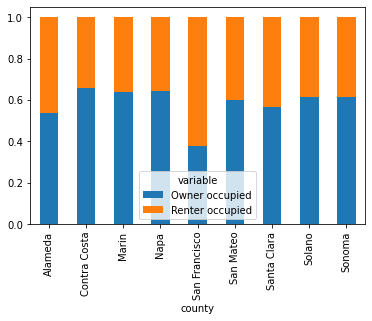

In [28]:
data_tenure_jur_summary.sum(level=['county','variable']).groupby(level='county').apply(pct).unstack(1).plot(kind='bar',stacked=True)